## 0. 모듈 임포트
-----

In [1]:
import glob, os, re
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

## 1. 데이터 읽어오기
-----

In [2]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:7])

데이터 크기: 187088
Examples:
 ['I hear you callin\', "Here I come baby"', 'To save you, oh oh', "Baby no more stallin'", 'These hands have been longing to touch you baby', "And now that you've come around, to seein' it my way", "You won't regret it baby, and you surely won't forget it baby", "It's unbelieveable how your body's calling for me"]


## 2. 데이터 정제
-----

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence


print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


#### 조건 1.  토큰 개수가 15개 이상이 되면 제외한다.

In [30]:
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence)== 0: 
        continue
    if sentence[-1] == ":":
        continue
    # 정제
    preprocessed_sentence = preprocess_sentence(sentence)
    # 정제후 길이 단어수 15개 이상인 제거
    if len(preprocessed_sentence.split()) > 15:
        continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개 확인 및 총 개수확인.
print(corpus[:10])
len(corpus)

['<start> i hear you callin , here i come baby <end>', '<start> to save you , oh oh <end>', '<start> baby no more stallin <end>', '<start> these hands have been longing to touch you baby <end>', '<start> and now that you ve come around , to seein it my way <end>', '<start> it s unbelieveable how your body s calling for me <end>', '<start> my body s callin for you <end>', '<start> my body s callin for you <end>', '<start> my body s callin for you tell me , what s your desire <end>', '<start> baby your wish is my deal oh yes it is baby <end>']


156013

### 토큰생성
#### 조건 2-1. 단어장 크기 12000 이상

In [5]:
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들며, 포함되지 못한 단어는 '<unk>'로 바꾼다.
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성한다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환한다.
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춘다.
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰준다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   4 186 ...   0   0   0]
 [  2  10 588 ...   0   0   0]
 [  2  52  42 ...   0   0   0]
 ...
 [  2   4  92 ...   0   0   0]
 [  2   9 156 ...   0   0   0]
 [  2 178  16 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f497be91590>


In [6]:
print(len(tensor))

156013


In [7]:
# 열길이 14로 변환
tensor = tensor[:,:15]
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]

print(f'src_input count:{len(src_input)}')
print(src_input[0])
print(f'tgt_input count:{len(tgt_input)}')
print(tgt_input[0])

src_input count:156013
[  2   4 186   7 838   5  90   4  68  52   3   0   0   0]
tgt_input count:156013
[  4 186   7 838   5  90   4  68  52   3   0   0   0   0]


## 4. 평가 데이터셋 분리
-----


#### 조건 2-2. 총 데이터의 20%를 평가데이터 셋으로 사용

In [8]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input,test_size=0.2)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


## 5. 인공지능 만들기
-----

### 학습모델  'lyricist' 생성

In [9]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size, name='lyricist')
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512   # 노드의 예제보다 2배 늘려주었다. 
hidden_size = 2048     # 노드의 예제보다 2배 늘려주었다. 
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

### lyricist가 훈련데이터 학습
#### 조건 3. 10epoch 안에 val_loss 2.2 수준 달성하기

In [10]:
#Check point
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weight_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

lyricist.compile(optimizer='adam', loss=loss)

# batch_sizefmf 설정해주니 epoch당 학습하량이 약 3000에서 976로 줄어들었다.
lyricist_hist = lyricist.fit(enc_train, dec_train, 
                             epochs=10, batch_size=128, 
                             validation_data = (enc_val, dec_val), 
                             callbacks=[checkpoint])

Epoch 1/10
976/976 [==============================] - 526s 518ms/step - loss: 3.5148 - val_loss: 2.7622

Epoch 00001: val_loss improved from inf to 2.76219, saving model to my_checkpoint.ckpt
Epoch 2/10
976/976 [==============================] - 510s 523ms/step - loss: 2.6058 - val_loss: 2.5053

Epoch 00002: val_loss improved from 2.76219 to 2.50531, saving model to my_checkpoint.ckpt
Epoch 3/10
976/976 [==============================] - 507s 520ms/step - loss: 2.1800 - val_loss: 2.3221

Epoch 00003: val_loss improved from 2.50531 to 2.32213, saving model to my_checkpoint.ckpt
Epoch 4/10
976/976 [==============================] - 509s 521ms/step - loss: 1.7852 - val_loss: 2.2172

Epoch 00004: val_loss improved from 2.32213 to 2.21716, saving model to my_checkpoint.ckpt
Epoch 5/10
976/976 [==============================] - 509s 521ms/step - loss: 1.4774 - val_loss: 2.1653

Epoch 00005: val_loss improved from 2.21716 to 2.16534, saving model to my_checkpoint.ckpt
Epoch 6/10
976/976 [====

### 학습 과정의 loss와 val_loss 시각화
* [케라스 기초 - JuHyang](https://ju-hyang.tistory.com/28)를 참조하였다.

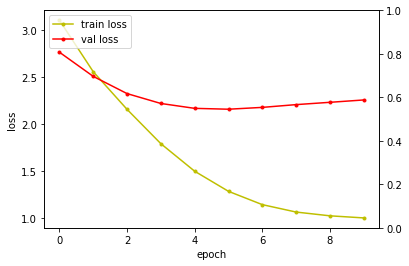

In [12]:
%matplotlib inline

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(lyricist_hist.history['loss'], 'y', marker='.', label='train loss')
loss_ax.plot(lyricist_hist.history['val_loss'], 'r', marker='.', label='val loss')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

### 학습완료한 모델 저장

In [13]:
lyricist.load_weights(checkpoint_path)

### lyricist 모델 요약 

In [14]:
print(lyricist.summary())

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6144512   
_________________________________________________________________
lstm (LSTM)                  multiple                  20979712  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
lyricist (Dense)             multiple                  24590049  
Total params: 85,276,897
Trainable params: 85,276,897
Non-trainable params: 0
_________________________________________________________________
None


### lylicist 가사생성 함수

In [15]:
def generate_text(lyricist, tokenizer, init_sentence="<start>", max_len=14):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장 생성
    #    1. 입력받은 문장의 텐서를 입력
    #    2. 예측된 값 중 가장 높은 확률인 word index추출
    #    3. 2에서 예측된 word index를 문장 뒤에 결합
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성종료
    while True:
        # 1
        predict = lyricist(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### lylicist 가사 쓰기 

In [29]:
generate_text(lyricist, tokenizer, init_sentence="<start> when")

'<start> when i m with you , all i get is wild thoughts <end> '

## 회고
-----

이번 노드를 수행하면서 처음에는 노드 예제와 다르게 붙은 추가 조건들을 이해하고 그것을 구현하는데 많은 시간을 썼다.   

그 중에서도 10 epoch 안에 val_loss 2.2 수준에 도달하기 위한 반복 학습에 많은 시간을 들였는데, 처음에는 매 epoch마다 3000개 이상의 학습이 이루어져서 많은 시간이 걸렸다. 이후 fit() 메소드 호출시 batch_size를 128로 지정해주자 학습량이 약 970개 정도로 줄어 시간이 줄어들어 테스트하기 용이해졌다.

또한 처음부터 val_loss가 2.2이하로 나오질 않아 여러번 수정후 재학습을 시도하였는데, val_loss를 낮추기 위해 수정한 항목은 다음과 같다.

* 예제와는 다르게 dataset 객체를 생성하지 않고 train_test_split 메소드로 
